In [2]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    run_dbscan, 
    transform_pca,
    silhouette_analysis,
    elbow_method,
    plot_davies_bouldin_scores,
    evaluar_calinski_harabasz
)


In [3]:
rfm_clientes_extranjeros = pd.read_csv('../../../dataset/rfm_clientes_extranjeros.csv')



print("cantidad de columnas: ", len(rfm_clientes_extranjeros.columns))

print("cantidad de filas: ", len(rfm_clientes_extranjeros))

cantidad de columnas:  18
cantidad de filas:  418


In [4]:
rfm_clientes_extranjeros.head()

,id_cliente,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
0,12347.0,3,7,4310.00,12,711.79,475.39,0.0,0.00,636.25,0.0,382.52,0.0,584.91,0.0,1294.32,0.00,224.82
1,12348.0,76,4,1437.24,15,652.80,187.44,0.0,0.00,327.00,0.0,0.00,0.0,0.00,270.0,0.00,0.00,0.00
2,12349.0,19,1,1457.55,9,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,1457.55,0.00
3,12350.0,311,1,294.40,16,0.00,0.00,294.4,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00
4,12352.0,37,7,1385.74,14,0.00,0.00,296.5,345.01,0.00,0.0,0.00,0.0,0.00,512.5,0.00,231.73,0.00


In [5]:
id_cliente= rfm_clientes_extranjeros['id_cliente'].copy()

id_cliente.head()

0    12347.0
1    12348.0
2    12349.0
3    12350.0
4    12352.0
Name: id_cliente, dtype: float64

In [6]:
rfm_clientes_extranjeros.drop(columns=['id_cliente'], inplace=True)

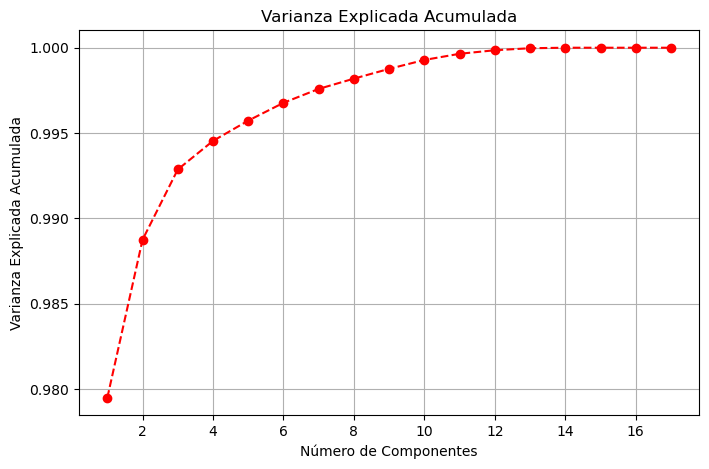

In [7]:
pca=PCA()

pca.fit(rfm_clientes_extranjeros)

var_exp=pca.explained_variance_ratio_

# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp)+1), var_exp.cumsum(), marker='o', linestyle='--', color='red')
plt.ylabel('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.title('Varianza Explicada Acumulada')
plt.grid()
plt.show()

In [8]:
componentes = transform_pca(rfm_clientes_extranjeros, 2)

# dichas compoenentes la transformamos en un dataframe de pandas , con los mismos indices que el dataframe original , para hacer un analisis psoteriormente de los grupos que forma k-means
dataframe_pca = pd.DataFrame(componentes, columns=['PC1', 'PC2'],index=rfm_clientes_extranjeros.index)

dataframe_pca.head()

,PC1,PC2
0,-0.254912,-0.014203
1,-0.052429,-0.029419
2,-0.193085,-0.066801
3,0.569435,0.076391
4,-0.146583,-0.079672


In [9]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import optuna
def objective(trial):
    eps = trial.suggest_float('eps', 0.1, 20, step=0.1)
    min_samples = trial.suggest_int('min_samples', 3, 50)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(dataframe_pca.values)

    # Filtrar casos con solo ruido o un único clúster
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        return -9999.0  # Penalización fuerte

    X = dataframe_pca.values

    silhouette = silhouette_score(dataframe_pca.values, labels)
    calinski = calinski_harabasz_score(dataframe_pca.values, labels)
    davies = davies_bouldin_score(dataframe_pca.values, labels)

    # Normalizamos CH (opcional) y restamos DB
    # Pesos: silhouette (60%), calinski (40%), davies (-20%)
    score = (
        0.6 * silhouette +
        0.4 * (calinski / 100) - 
        0.2 * davies
    )

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)

print("\nMejor puntuación compuesta obtenida:")
print(study.best_value)


/home/agustin/miniconda3/envs/ecommerce/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-14 11:10:16,015] A new study created in memory with name: no-name-98f62f34-31d6-421e-b0f1-7bde2ba3e347
[I 2025-07-14 11:10:16,025] Trial 0 finished with value: -9999.0 and parameters: {'eps': 11.200000000000001, 'min_samples': 31}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:10:16,032] Trial 1 finished with value: -9999.0 and parameters: {'eps': 5.4, 'min_samples': 9}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:10:16,046] Trial 2 finished with value: -9999.0 and parameters: {'eps': 8.3, 'min_samples': 38}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:10:16,054] Trial 3 finished with value: -9999.0 and parameters: {'eps': 10.1, 'min_samples': 46}. Best is trial 0 with value: -99

Mejores hiperparámetros encontrados:
{'eps': 0.1, 'min_samples': 31}

Mejor puntuación compuesta obtenida:
1.5626835766830736


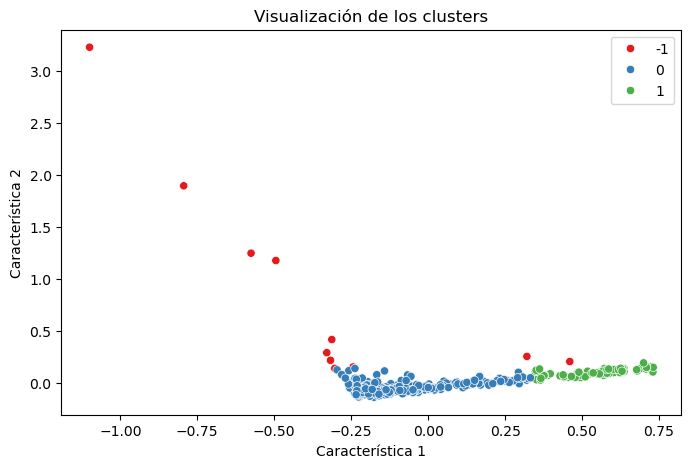

Run ID final clustering: b28e7c5818ea4d3da59a1dd746dcc6c6
🏃 View run Final_Clustering_dbscan at: http://localhost:5000/#/experiments/783044773072081940/runs/b28e7c5818ea4d3da59a1dd746dcc6c6
🧪 View experiment at: http://localhost:5000/#/experiments/783044773072081940


,PC1,PC2,Cluster
0,-0.254912,-0.014203,0
1,-0.052429,-0.029419,0
2,-0.193085,-0.066801,0
3,0.569435,0.076391,1
4,-0.146583,-0.079672,0


In [10]:
data_clust = run_dbscan(dataframe_pca, 0.1, 31 ,experiment_name="DBSCAN_Clientes_Extranjeros")

data_clust.head()

In [11]:
id_cliente.index = data_clust.index

In [12]:
data_clust['id_cliente'] = id_cliente

In [13]:
data_clust = data_clust[['id_cliente', 'PC1', 'PC2', 'Cluster']]

data_clust.head()

,id_cliente,PC1,PC2,Cluster
0,12347.0,-0.254912,-0.014203,0
1,12348.0,-0.052429,-0.029419,0
2,12349.0,-0.193085,-0.066801,0
3,12350.0,0.569435,0.076391,1
4,12352.0,-0.146583,-0.079672,0


In [14]:
rfm_clientes_extranjeros['Cluster']=data_clust['Cluster']
rfm_clientes_extranjeros['id_cliente']=id_cliente

In [15]:
rfm_clientes_extranjeros.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Cluster', 'id_cliente'],
      dtype='object')

In [16]:
cluster_summary = rfm_clientes_extranjeros.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary)

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,id_cliente
Cluster,,,,,,,,,,,,,,,,,,
-1,55.545455,37.090909,69131.147273,11.545455,3150.580909,5352.369091,5085.669091,5430.236364,1776.988182,5353.836364,6193.344545,4849.358182,7758.723636,7013.546364,8300.423636,6735.876364,2130.194545,13561.363636
0,57.826979,3.917889,2048.666070,12.090909,81.899765,152.796891,71.149795,155.083109,69.951994,172.091496,182.435982,161.401026,164.762962,212.085044,290.630323,277.291232,57.086452,12797.167155
1,302.560606,1.196970,535.372273,12.257576,97.669394,165.699697,115.539242,80.163485,76.300455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12983.136364


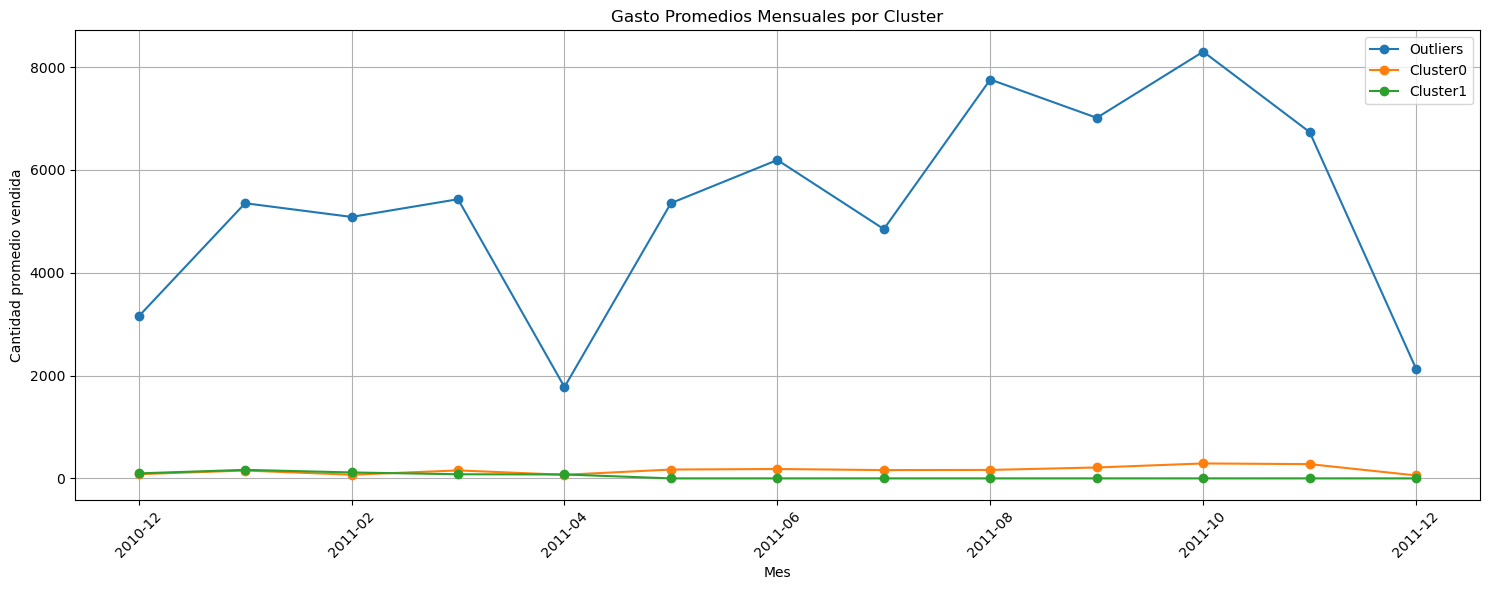

In [24]:
outliers_mes= cluster_summary.iloc[0].T
cluster0_mes= cluster_summary.iloc[1].T
cluster1_mes= cluster_summary.iloc[2].T

columnas_fechas = [col for col in rfm_clientes_extranjeros.columns if col.startswith('201')]

outliers_mes=outliers_mes[columnas_fechas]
cluster0_mes=cluster0_mes[columnas_fechas]
cluster1_mes=cluster1_mes[columnas_fechas]

ventas_promedios_mensuales=pd.concat([outliers_mes,cluster0_mes,cluster1_mes],axis=1)
ventas_promedios_mensuales.columns=['Outliers','Cluster0','Cluster1']

ventas_promedios_mensuales.plot(
    figsize=(15, 6),
    title='Gasto Promedios Mensuales por Cluster',
    marker='o' ,
    markersize=6 )

plt.xlabel("Mes")
plt.ylabel("Cantidad promedio vendida")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
ventas_promedios_mensuales

,Outliers,Cluster0,Cluster1
2010-12,3150.580909,81.899765,97.669394
2011-01,5352.369091,152.796891,165.699697
2011-02,5085.669091,71.149795,115.539242
2011-03,5430.236364,155.083109,80.163485
2011-04,1776.988182,69.951994,76.300455
2011-05,5353.836364,172.091496,0.000000
2011-06,6193.344545,182.435982,0.000000
2011-07,4849.358182,161.401026,0.000000
2011-08,7758.723636,164.762962,0.000000
2011-09,7013.546364,212.085044,0.000000


In [25]:
rfm_columnas=['Recency', 'Frequency', 'Monetary']
outliers_rfm=cluster_summary.iloc[0].T
cluster0_rfm=cluster_summary.iloc[1].T
cluster1_rfm=cluster_summary.iloc[2].T

outliers_rfm=outliers_rfm[rfm_columnas]
cluster0_rfm=cluster0_rfm[rfm_columnas]
cluster1_rfm=cluster1_rfm[rfm_columnas]

rfm_promedio_cluster=pd.concat([outliers_rfm,cluster0_rfm,cluster1_rfm],axis=1)
rfm_promedio_cluster.columns=['Outliers','Cluster 0','Cluster 1']

In [26]:
rfm_promedio_cluster

,Outliers,Cluster 0,Cluster 1
Recency,55.545455,57.826979,302.560606
Frequency,37.090909,3.917889,1.196970
Monetary,69131.147273,2048.666070,535.372273


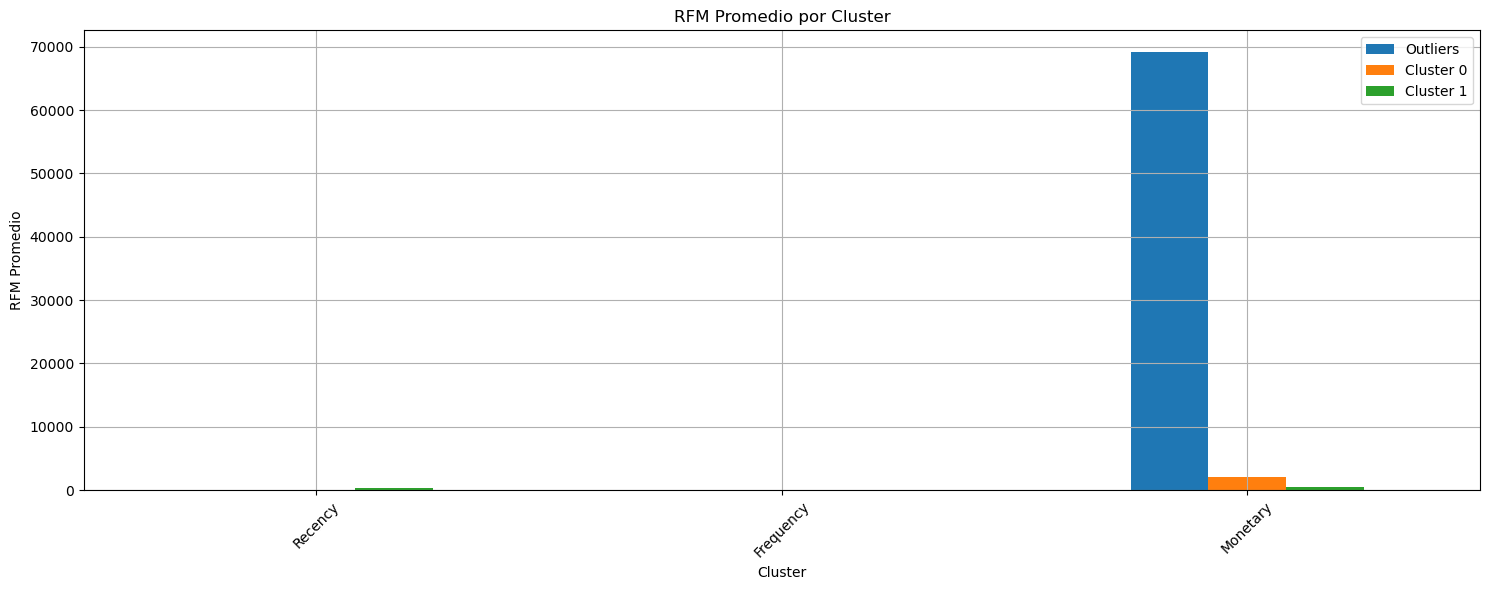

In [27]:
sin_outliers= rfm_promedio_cluster[['Outliers','Cluster 0','Cluster 1']]

sin_outliers.plot(kind='bar', figsize=(15, 6))
plt.title('RFM Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('RFM Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
clientes_extrajeros_cluster= rfm_clientes_extranjeros[['id_cliente','Cluster']]
clientes_extrajeros_cluster.head()

clientes_extrajeros_cluster.to_csv('../../../dataset/dbscan_clientes_extrajeros_cluster.csv',index=False)